In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline


## 1.  Get Camera Calibration Matrix

In [2]:
# prepare object points
objpoints = []
imgpoints = []

objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for file in os.listdir('camera_cal'):
    img = cv2.imread('camera_cal/' + file)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         fig = plt.figure()
#         plt.imshow(img)
#     else:
#         print('No chessboard!')
#         fig = plt.figure()
#         plt.imshow(img)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. Distortion correction

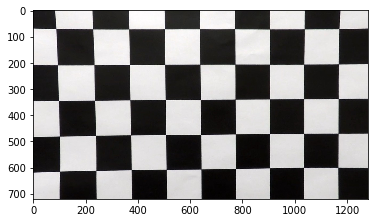

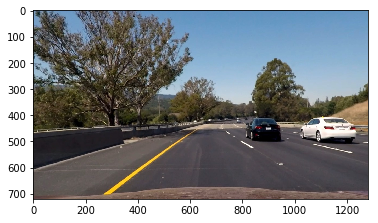

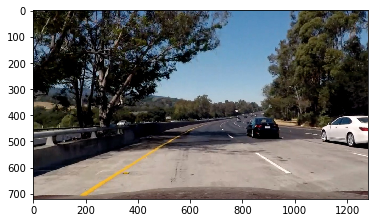

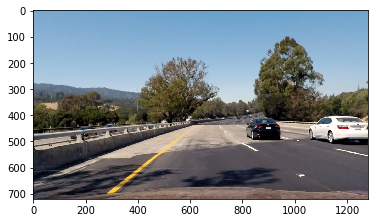

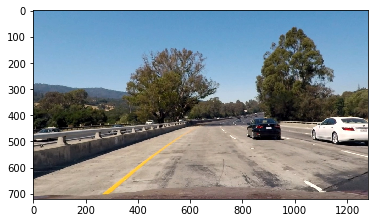

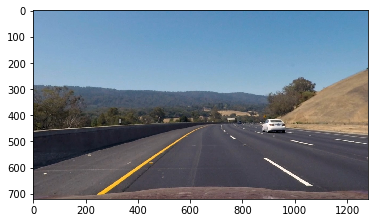

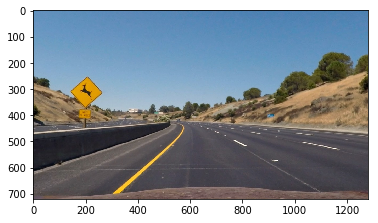

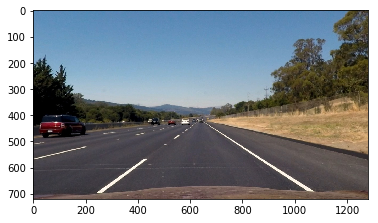

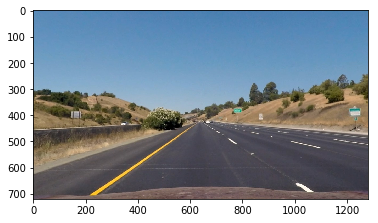

In [3]:
img = cv2.imread('camera_cal/' + 'calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/' + 'calibration1.jpg', dst)
fig = plt.figure()
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

undistorted_images = []
for file in os.listdir('test_images'):
    img = cv2.imread('test_images/' + file)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_images.append(dst)
    cv2.imwrite('output_images/' + file.split('.')[0] + '_2.jpg', dst)
    fig = plt.figure()
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

## 3. Binary Threshold Images

/Users/bwuzhang/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


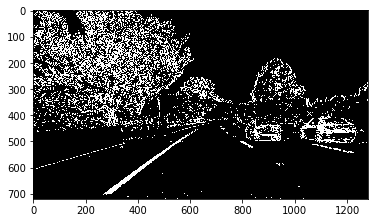

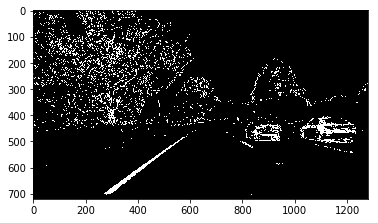

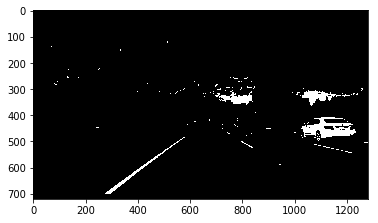

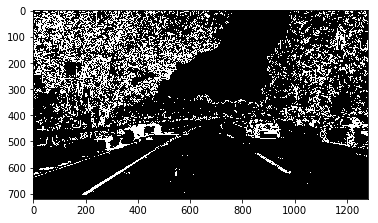

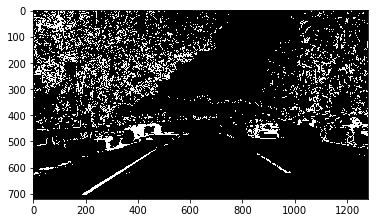

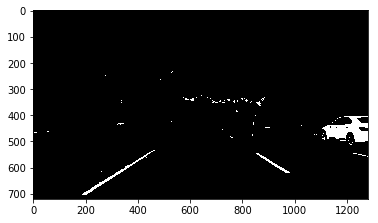

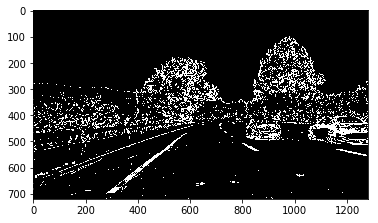

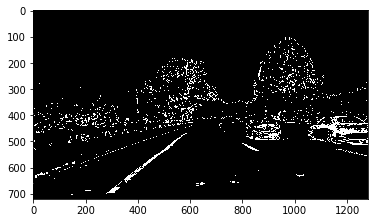

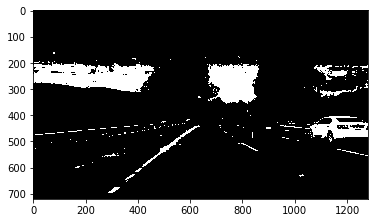

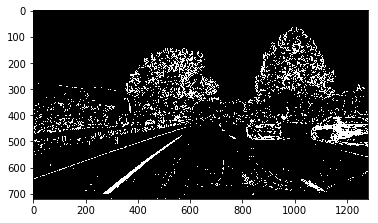

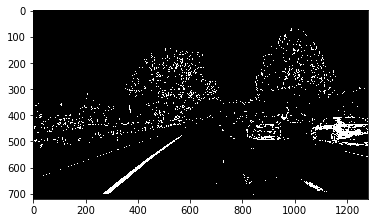

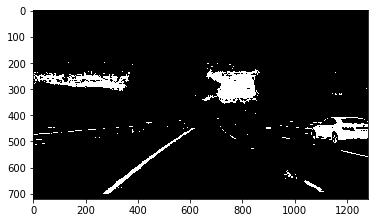

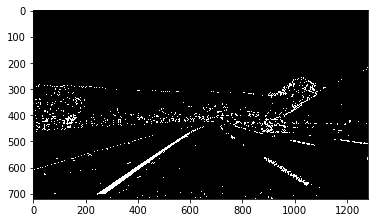

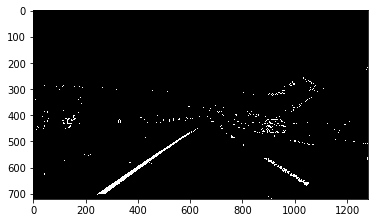

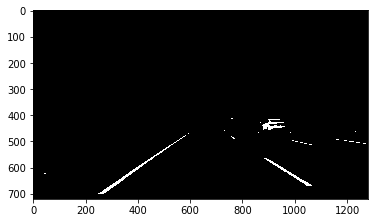

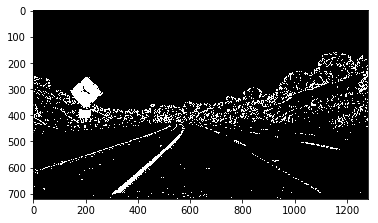

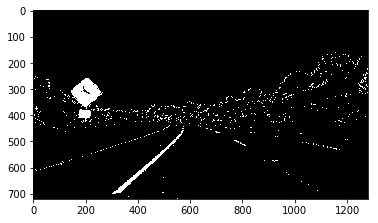

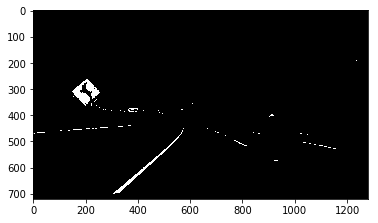

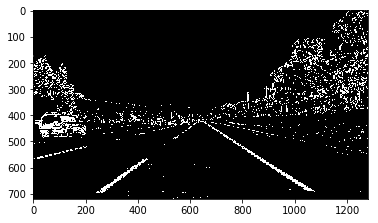

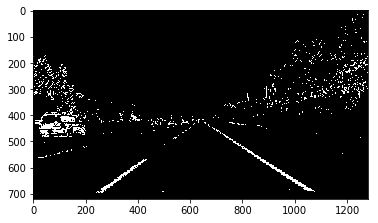

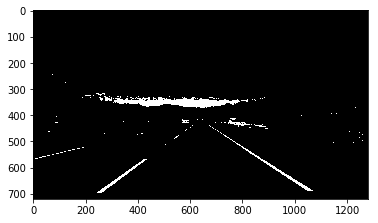

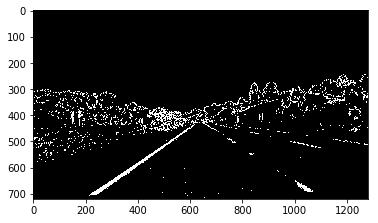

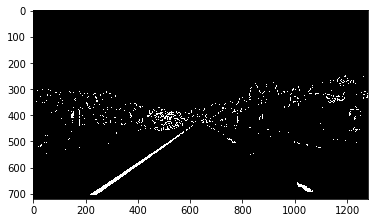

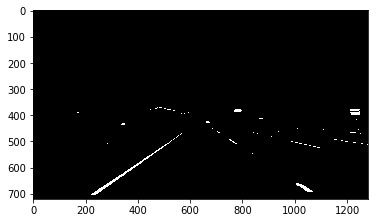

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.absolute(sobel)
    sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel>thresh[0]) & (sobel<thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobel_y**2 + sobel_x**2)
    sobel = np.uint8(255*sobel/np.max(sobel))
    mag_binary = np.zeros_like(sobel)
    mag_binary[(sobel>mag_thresh[0]) & (sobel<mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    dir_binary = np.zeros_like(sobel)
    dir_binary[(sobel>thresh[0]) & (sobel<thresh[1])] = 1
    return dir_binary

def thresh_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def pipeline_new(img, s_thresh=(170, 255), sx_thresh=(20, 100), ):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold h values
    h_binary = np.zeros_like(h_channel)
    h_binary[h_channel < 40] = 1

    dir_binary = dir_threshold(original_image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) | ((h_binary == 1) & (dir_binary == 1))] = 1
    return combined_binary

def threshold_Channel(channel,thresh):
    retval, binary = cv2.threshold(channel.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return binary


def channel_Isolate(image,channel):
    ## Takes in only RBG images
    if (channel == 'R'):
        return image[:,:,2]

    elif (channel == 'G'):
        return image[:,:,1]

    elif (channel == 'B'):
        return image[:,:,0]

    elif (channel == 'H'):
        HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        return HSV[:,:,0]

    elif (channel == 'S'):
        HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        return HSV[:,:,1]

    elif (channel == 'V'):
        HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        return HSV[:,:,2]

    elif (channel == 'L'):
        HLS = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        return HLS[:,:,1]

    elif (channel == 'Cb'):
        YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        return YCrCb[:,:,2]

    elif (channel == 'U'):
        LUV = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
        return LUV[:,:,2]

    else:
        raise Error("Channel must be either R, G, B, H, S, V, L, Cb, U")


def threshhold_pipeline(image):
    red_threshed = threshold_Channel(channel_Isolate(image,'R'),(220,255))
    V_threshed = threshold_Channel(channel_Isolate(image,'V'),(220,255))
    # Cb_tresh = threshold_Channel(channel_Isolate(trans,'Cb'),(200,255))
    HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))

    white_3 = cv2.inRange(image, (200,200,200), (255,255,255))

    bit_layer = red_threshed | V_threshed | yellow | white | white_2 | white_3
    return bit_layer

binary_images = []
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# for file in os.listdir('output_images'):
#     if file.endswith('_2.jpg'):
for image in undistorted_images:
    original_image = image
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(original_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    # plt.figure()
    # plt.imshow(gradx, cmap='gray')

    grady = abs_sobel_thresh(original_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    # plt.figure()
    # plt.imshow(grady, cmap='gray')

    mag_binary = mag_thresh(original_image, sobel_kernel=ksize, mag_thresh=(30, 100))
    # plt.figure()
    # plt.imshow(mag_binary, cmap='gray')

    dir_binary = dir_threshold(original_image, sobel_kernel=15, thresh=(0.7, 1.3))
    # plt.figure()
    # plt.imshow(dir_binary, cmap='gray')

#         plt.figure()
#         plt.imshow(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)), cmap='gray')

#         result = pipeline_new(original_image)
#         plt.figure()
#         plt.imshow(result, cmap='gray')

    result = thresh_pipeline(original_image)
    plt.figure()
    plt.imshow(result, cmap='gray')
    
    result = thresh_pipeline(original_image, sx_thresh=(40, 100))
    plt.figure()
    plt.imshow(result, cmap='gray')
    
    result = threshhold_pipeline(original_image)
    plt.figure()
    plt.imshow(result, cmap='gray')
    
    binary_images.append(result)
#         plt.figure()
#         plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

## 4. Perspective transformation

### Hard code a region of interest

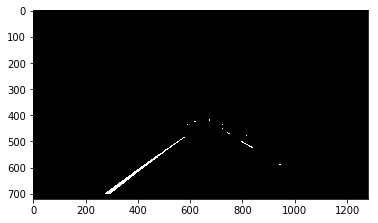

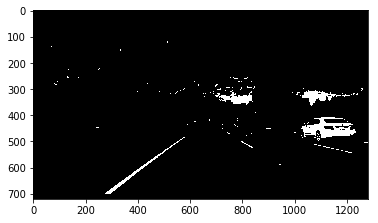

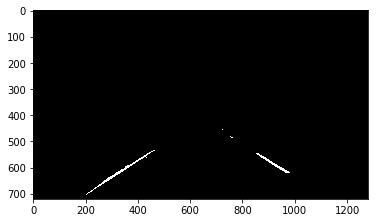

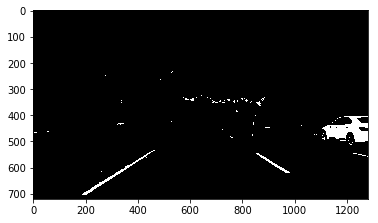

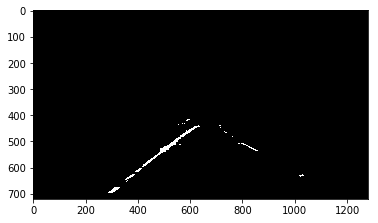

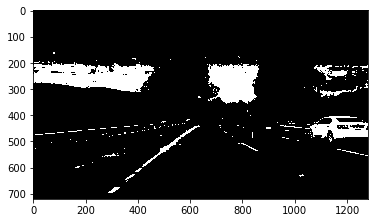

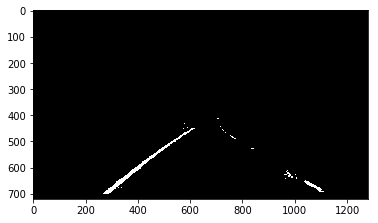

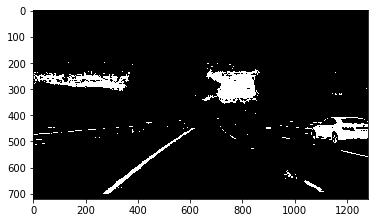

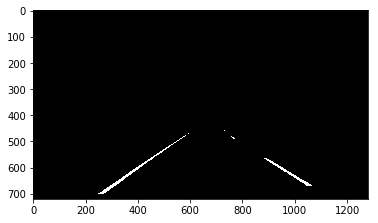

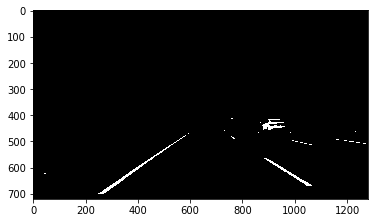

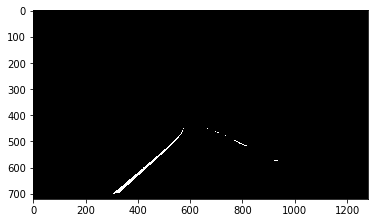

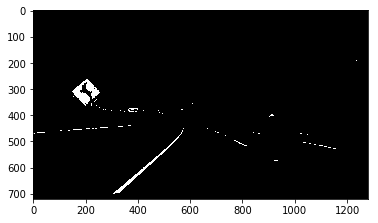

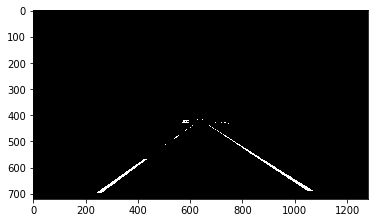

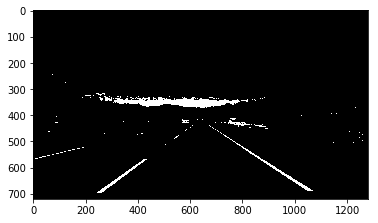

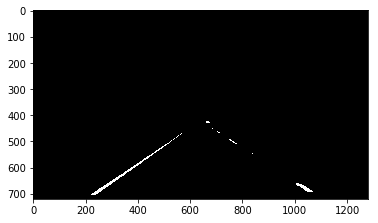

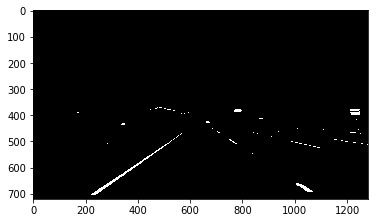

In [5]:
imshape = binary_images[0].shape
vertices = np.array([[(180,imshape[0]),(600, 400), (700, 400),(1200,imshape[0])]], dtype=np.int32)

masked_images = []
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

for image in binary_images:
    masked_image = region_of_interest(image, vertices)
    masked_images.append(masked_image)
    plt.figure()
    plt.imshow(masked_image, cmap="gray")
    plt.figure()
    plt.imshow(image, cmap="gray")

### Hard code a perspective transformation

In [6]:
# src = np.float32(
#     [[120, 720],
#      [550, 470],
#      [700, 470],
#      [1160, 720]])

# dst = np.float32(
#     [[200,720],
#      [200,0],
#      [1080,0],
#      [1080,720]])

src = np.float32(
    [[262, 700],
     [429, 579],
     [874, 579],
     [1060, 699]])

# dst = np.float32(
#     [[500,720],
#      [500,650],
#      [700,650],
#      [700,720]])

dst = np.float32(
    [[550,710],
     [550,600],
     [650,600],
     [650,710]])

# dst = np.float32(
#     [[500,720],
#      [500,500],
#      [700,500],
#      [700,720]])

# src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
# dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

/Users/bwuzhang/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


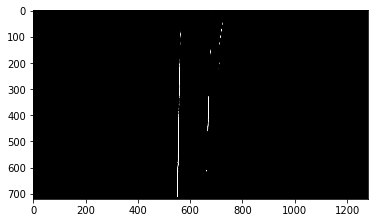

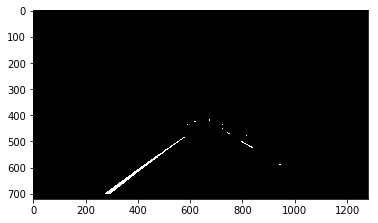

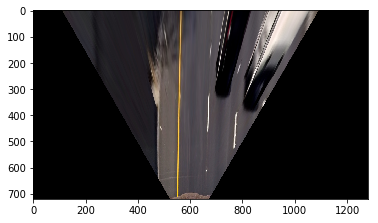

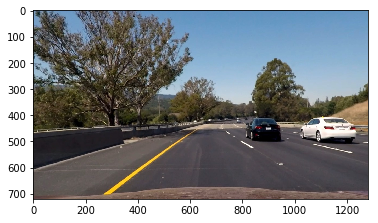

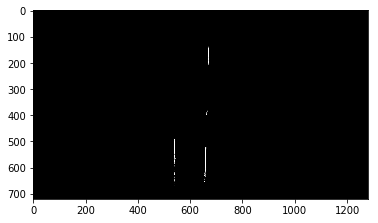

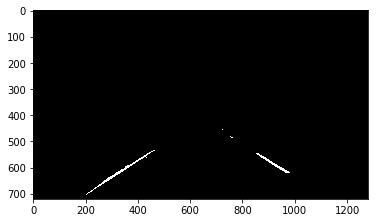

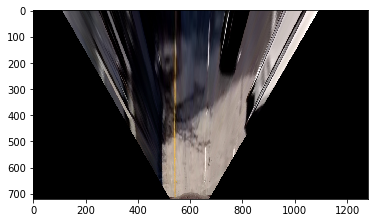

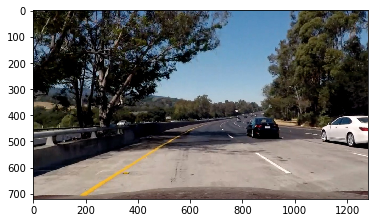

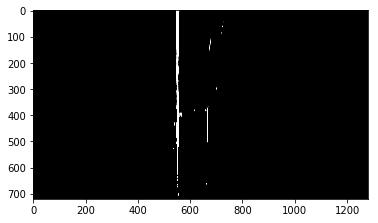

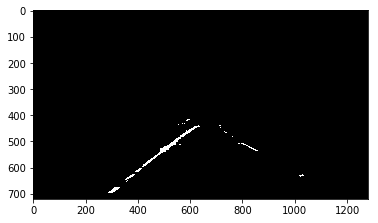

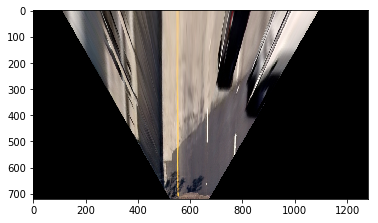

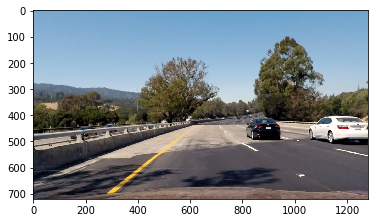

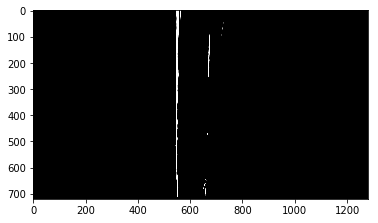

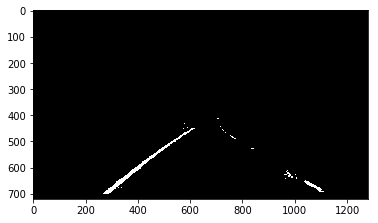

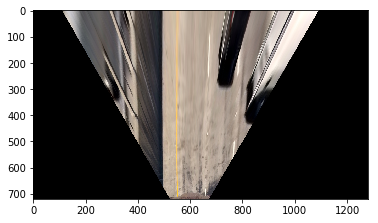

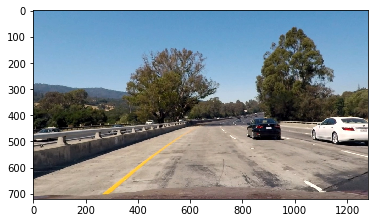

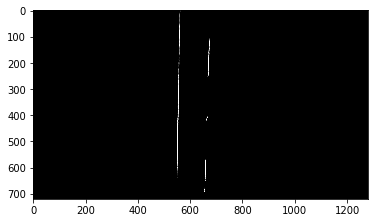

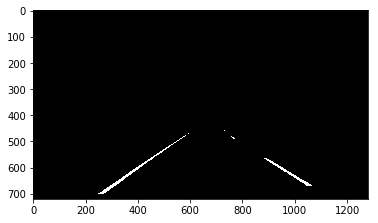

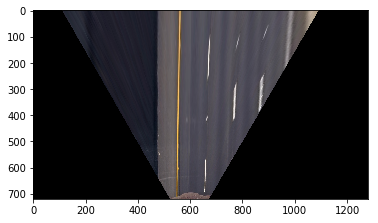

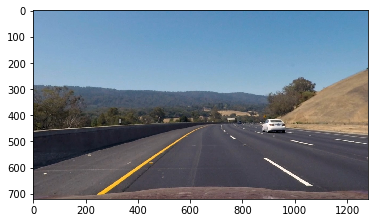

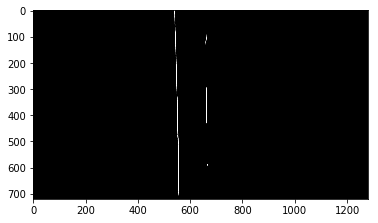

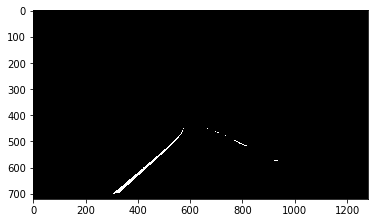

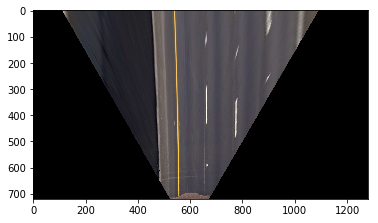

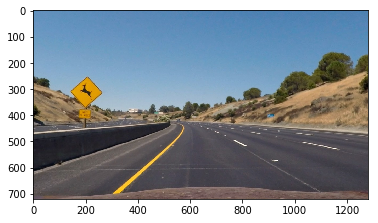

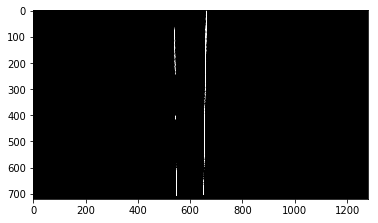

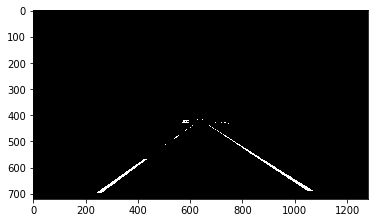

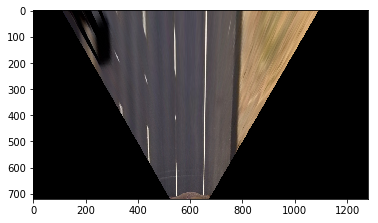

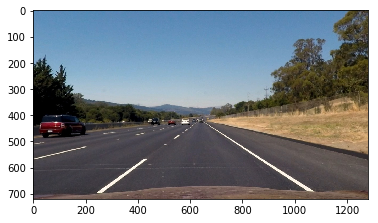

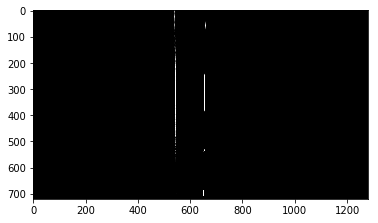

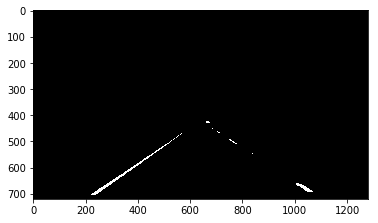

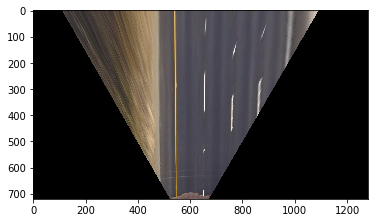

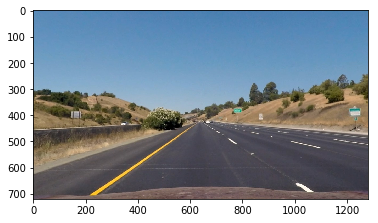

In [7]:
warped_images = []
# for image in undistorted_images:
for masked_image, undistorted_image in zip(masked_images, undistorted_images):
    warped = cv2.warpPerspective(masked_image, M, (imshape[1], imshape[0]))
    warped_images.append(warped)
    plt.figure()
    plt.imshow(warped, cmap="gray")
    
    plt.figure()
    plt.imshow(masked_image, cmap="gray")
    
    warped = cv2.warpPerspective(undistorted_image, M, (imshape[1], imshape[0]))
    plt.figure()
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), cmap="gray")
    
    plt.figure()
    plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))

# tmp = masked_images[1]

# plt.figure()
# plt.imshow(tmp, cmap="gray")

# warped = cv2.warpPerspective(tmp, M, (imshape[1], imshape[0]))
# plt.figure()
# plt.imshow(warped, cmap="gray")

# plt.figure()
# plt.imshow(tmp, cmap="gray")

# warped = cv2.warpPerspective(undistorted_images[1], M, (imshape[1], imshape[0]))
# plt.figure()
# plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), cmap="gray")

# plt.figure()
# plt.imshow(cv2.cvtColor(undistorted_images[1], cv2.COLOR_BGR2RGB))


## 5. Detect lanes

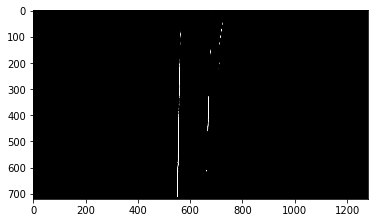

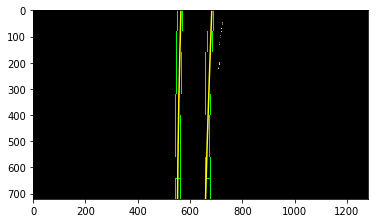

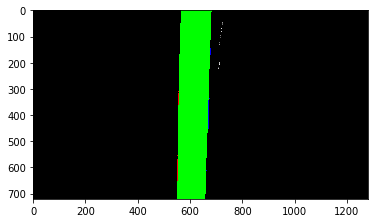

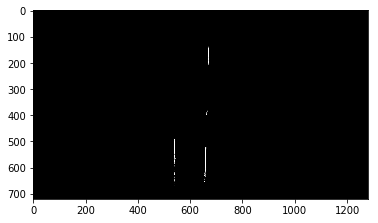

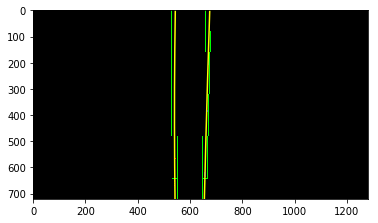

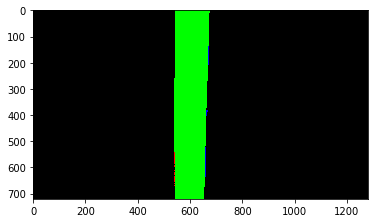

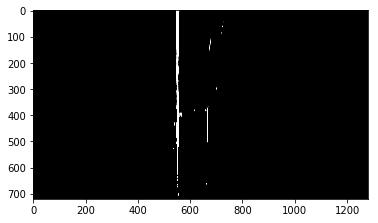

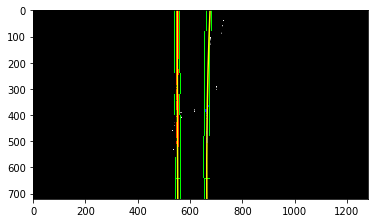

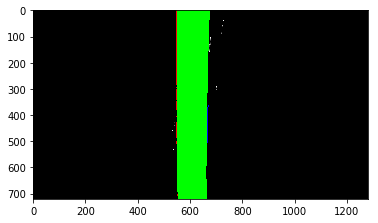

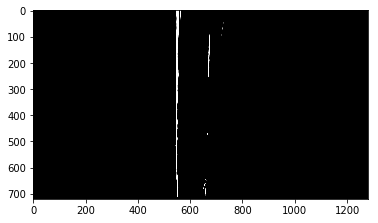

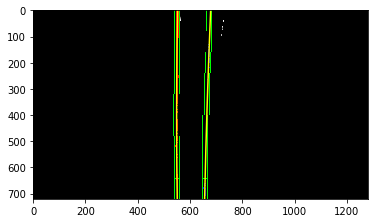

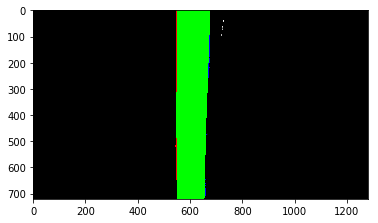

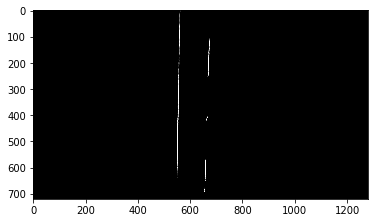

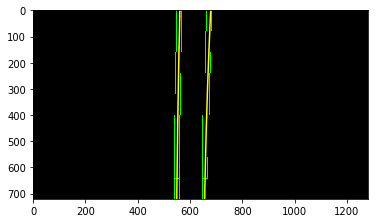

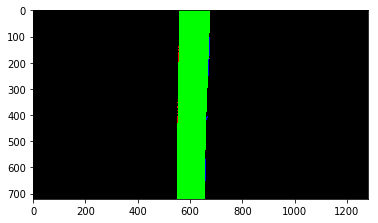

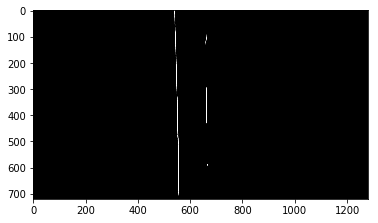

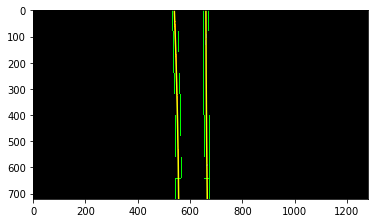

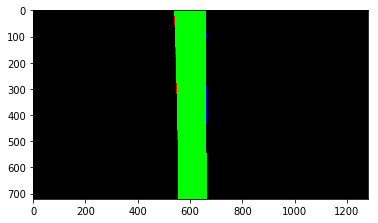

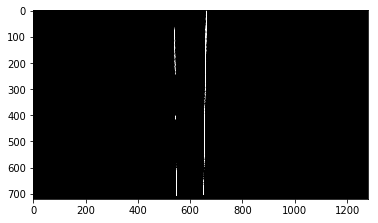

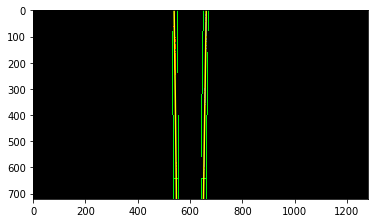

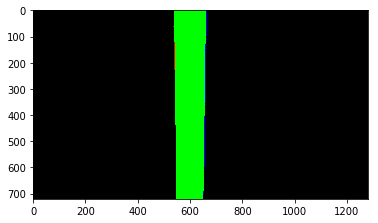

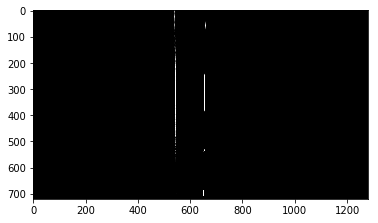

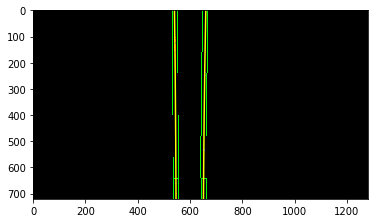

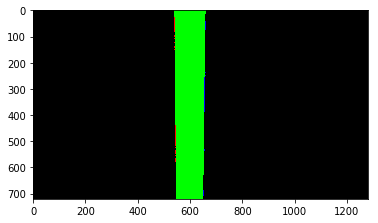

In [25]:
def evaluate_poly(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

def highlight_lane_line_area(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = np.zeros_like(mask_template)
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1
    return area_mask

def detect_lane(binary_warped, left_fit=None, right_fit=None):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    leftx_base = np.argmax(histogram[:600])
    rightx_base = np.argmax(histogram[600:]) + 600

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    if (left_fit is None) or (right_fit is None):
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 10
        # Set minimum number of pixels found to recenter window
        minpix = 5
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        margin = 30
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + \
                                       left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + \
                                                                             left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + \
                                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + \
                                                                               right_fit[1]*nonzeroy + right_fit[2] + margin))) 

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curvature = np.absolute(((1 + (2 * left_fit[0] * 500 + left_fit[1])**2) ** 1.5) /(2 * left_fit[0]))
    right_curvature = np.absolute(((1 + (2 * right_fit[0] * 500 + right_fit[1])**2) ** 1.5) /(2 * right_fit[0]))
    curvature = ((left_curvature + right_curvature) / 2) / 100 * 3.7
    
    offset = (evaluate_poly(719, right_fit) - evaluate_poly(719, left_fit)) / 2 - 50
    offset = offset/100*3.7
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    highlight_mask = highlight_lane_line_area(out_img[:,:,1], left_fit, right_fit)
    out_img[highlight_mask == 1] = [0, 255, 0]
    return out_img, curvature, offset, left_fit, right_fit
    
lane_images = []
curvatures = []
offsets = []
for binary_warped in warped_images:
    plt.figure()
    plt.imshow(binary_warped, cmap='gray')

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
#     plt.figure()
#     plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:600])
#     print(leftx_base)
    rightx_base = np.argmax(histogram[600:]) + 600
#     print(rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 10
    # Set minimum number of pixels found to recenter window
    minpix = 5
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_curvature = np.absolute(((1 + (2 * left_fit[0] * 500 + left_fit[1])**2) ** 1.5) /(2 * left_fit[0]))
    right_curvature = np.absolute(((1 + (2 * right_fit[0] * 500 + right_fit[1])**2) ** 1.5) /(2 * right_fit[0]))
    curvature = ((left_curvature + right_curvature) / 2) / 100 * 3.7
#     print(curvature)
    curvatures.append(curvature)
    
    offset = (evaluate_poly(719, right_fit) - evaluate_poly(719, left_fit)) / 2 - 50
#     print(offset)
    offset = offset/100*3.7
#     print(offset)
    offsets.append(offset)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    highlight_mask = highlight_lane_line_area(out_img[:,:,1], left_fit, right_fit)
    out_img[highlight_mask == 1] = [0, 255, 0]
    result = out_img
    plt.figure()
    plt.imshow(result)
    lane_images.append(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

## 6. Unwarp lane image

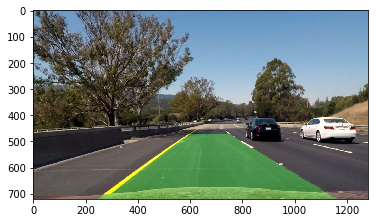

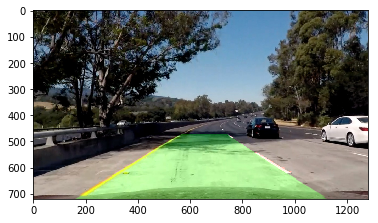

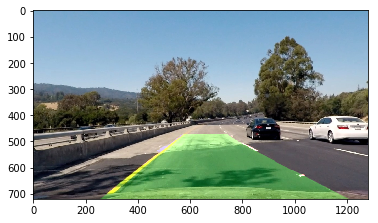

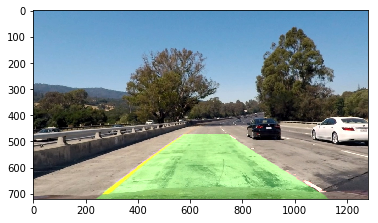

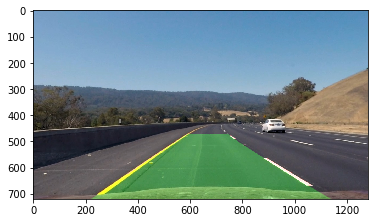

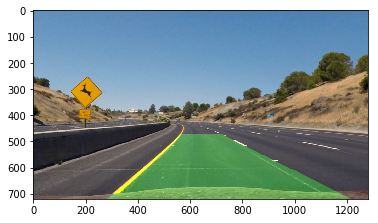

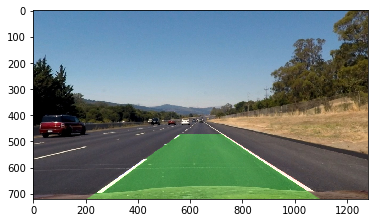

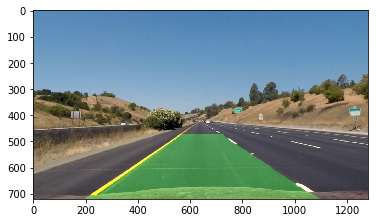

In [10]:
unwarped_lane_images = []
for lane_image, undistorted_image in zip(lane_images, undistorted_images):
    unwarped_lane_image = cv2.warpPerspective(lane_image, Minv, (imshape[1], imshape[0]))
    unwarped_lane_image = cv2.addWeighted(undistorted_image, 1, unwarped_lane_image, 0.3, 0)
    unwarped_lane_images.append(unwarped_lane_image)
    plt.figure()
    plt.imshow(cv2.cvtColor(unwarped_lane_image, cv2.COLOR_BGR2RGB))

## 7. Add text description

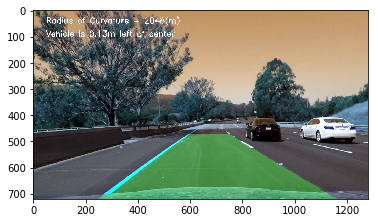

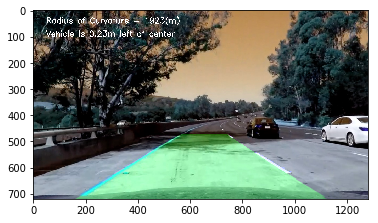

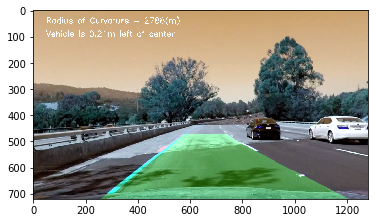

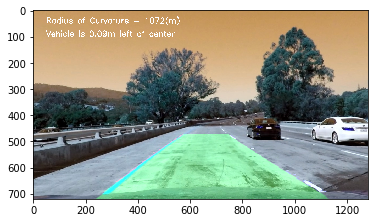

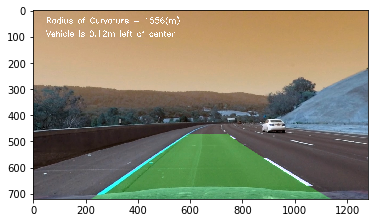

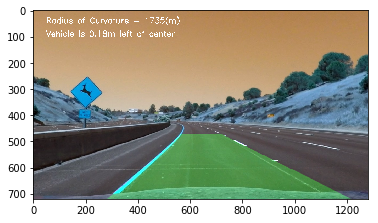

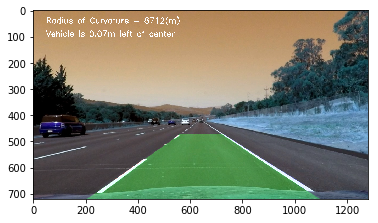

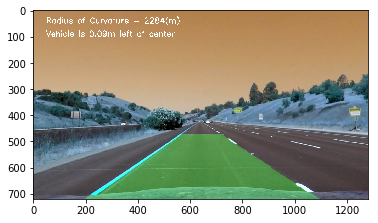

In [27]:
final_images = []
def add_text(img, curvature, offset):
    final_image = np.copy(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_image, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "right" if offset < 0 else "left"
    cv2.putText(final_image, 'Vehicle is %.2fm %s of center' % (np.abs(offset), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    
    return final_image
for img, curvature, offset in zip(unwarped_lane_images, curvatures, offsets):
    final_image = add_text(img, curvature, offset)
    plt.figure()
    plt.imshow(final_image)
    final_images.append(final_image)

## 8. The pipeline

In [23]:
global left_fit
left_fit = None
global right_fit
right_fit = None
def pipeline(img):
    global left_fit
    global right_fit
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
#     img_binary_thresh = thresh_pipeline(img_undistorted)
    img_binary_thresh = threshhold_pipeline(img_undistorted)
    
    img_binary_masked = region_of_interest(img_binary_thresh, vertices)
    
    img_binary_warped = cv2.warpPerspective(img_binary_masked, M, (imshape[1], imshape[0]))
    
    img_lane_warped, curvature, offset, left_fit, right_fit = detect_lane(img_binary_warped, left_fit, right_fit)
    
    img_lane_unwarped = cv2.warpPerspective(img_lane_warped, Minv, (imshape[1], imshape[0]))
    
    img_w_lane = cv2.addWeighted(img_undistorted, 1, img_lane_unwarped, 0.3, 0)
    
    img_output = add_text(img_w_lane, curvature, offset)
    
    return img_output
    
# for file in os.listdir('test_images'):
#     img = cv2.imread('test_images/' + file)
#     img_output = pipeline(img)
    
#     plt.figure()
#     plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))

## 9. Generate video

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


100%|█████████▉| 1260/1261 [02:43<00:00,  8.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 3min 25s, sys: 13.6 s, total: 3min 39s
Wall time: 2min 45s
